In [1]:
import numpy as np
import tensorflow as tf
import keras_cv
from sklearn.model_selection import train_test_split

data_path = "/kaggle/input/blood-cells/balanced_cleaned_training_set.npz"

# Load data and normalize
data = np.load(data_path, allow_pickle=True)
X = data['images']
y = data['labels']

# Convert to int and normalize
# X = X.astype(int)
# X = (X / 255).astype('float32')
y = tf.keras.utils.to_categorical(y)

E0000 00:00:1732193532.806550      77 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1121 12:52:12.815176090      77 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1121 12:52:12.815191679      77 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1121 12:52:12.815214842      77 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1121 12:52:12.815218395      77 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1121 12:52:12.815221201      77 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


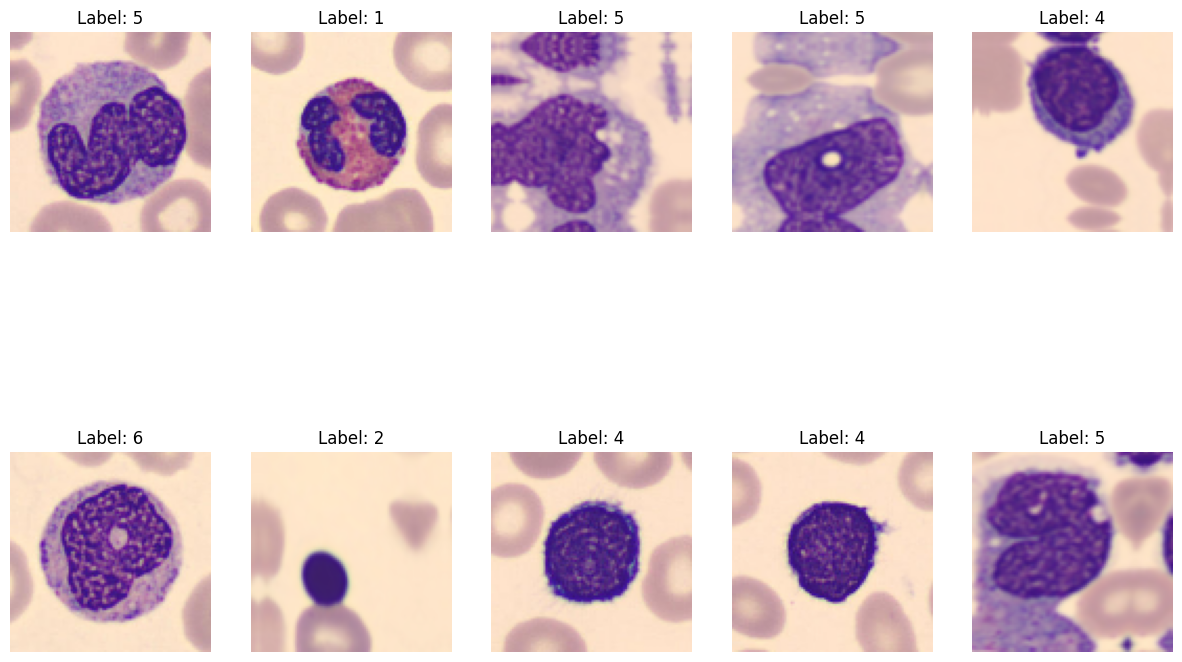

In [2]:
import matplotlib.pyplot as plt

# Plot 10 random images from X
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X.shape[0])
    plt.imshow(X[random_idx])
    plt.title(f"Label: {np.argmax(y[random_idx])}")
    plt.axis('off')
plt.show()

In [3]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, stratify=y)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

I0000 00:00:1732193582.334590      77 service.cc:145] XLA service 0x58d99b480db0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732193582.334643      77 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1732193582.334648      77 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1732193582.334651      77 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1732193582.334654      77 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1732193582.334656      77 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1732193582.334659      77 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1732193582.334662      77 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1732193582.334665      77 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


In [4]:

def augment_image(image, label):
    layers = [
        keras_cv.layers.ChannelShuffle(groups=3),
        keras_cv.layers.AugMix(value_range=(0, 1), severity=0.3, num_chains=3, chain_depth=[1, 3], alpha=1.0),
        keras_cv.layers.GridMask(ratio_factor=(0, 0.5), rotation_factor=0.15, fill_mode="constant", fill_value=0.0),
        keras_cv.layers.RandAugment(value_range=(0, 1), augmentations_per_image=3, magnitude=0.5, magnitude_stddev=0.15, rate=0.9090909090909091, geometric=True),                     
    ]
    
    choices = [1, 2, 3, 4]

    # Use numpy to sample from the choices with specified probabilities
    num_augmentations = np.random.choice(choices, p=probabilities)

    pipeline = keras_cv.layers.RandomAugmentationPipeline(
        layers=layers, augmentations_per_image=num_augmentations, rate=1.0
    )

    aug_image = pipeline(image)
    return aug_image, label

def do_nothing(image, label):
    return image, label

In [5]:
probabilities = [0, 0, 0, 0]

def augment_dataset(dataset, X, y, augmentations_per_image, new_probabilities):
    num_datasets = augmentations_per_image
    datasets = [0 for i in range(num_datasets)]

    global probabilities
    probabilities = new_probabilities
    
    for i in range(num_datasets):
        datasets[i] = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
        datasets[i] = datasets[i].batch(32).prefetch(tf.data.AUTOTUNE)

    X_augmented = [0 for i in range(num_datasets)]
    y_augmented = [0 for i in range(num_datasets)]

    for i in range(num_datasets):
        X_augmented[i], y_augmented[i] = next(iter(datasets[i].unbatch().batch(len(X))))

    X_datasets_to_concatenate = [X] + [aug.numpy() for aug in X_augmented]
    y_datasets_to_concatenate = [y] + [aug.numpy() for aug in y_augmented]

    X_combined = np.concatenate(X_datasets_to_concatenate, axis=0)
    y_combined = np.concatenate(y_datasets_to_concatenate, axis=0)

    return X_combined, y_combined 

In [6]:
# Constants
train_augmentations_per_image = 8 # 16
train_probabilities = [0.4, 0.4, 0.15, 0.05] #[0.2, 0.25, 0.40, 0.15]
val_augmentations_per_image = 8 # 8
val_probabilities = [0.2, 0.35, 0.35, 0.1]

print(f"Making {train_augmentations_per_image} augmentations per trainning")
print(f"Probabilities are: {train_probabilities}")
print(f"Making {val_augmentations_per_image} augmentations per validation")
print(f"Probabilities are: {val_probabilities}")

X_train_combined, y_train_combined = augment_dataset(train_dataset, X_train, y_train, train_augmentations_per_image, train_probabilities)
X_val_combined, y_val_combined = augment_dataset(val_dataset, X_val, y_val, val_augmentations_per_image, val_probabilities)

Making 8 augmentations per trainning
Probabilities are: [0.4, 0.4, 0.15, 0.05]
Making 8 augmentations per validation
Probabilities are: [0.2, 0.35, 0.35, 0.1]


In [7]:
# np.savez(f"/kaggle/working/{train_augmentations_per_image}_nocleanval_balanced_heavy_full_and_augMix_training_data.npz", images=X_train_combined, labels=y_train_combined)
# np.savez(f"/kaggle/working/{train_augmentations_per_image}_train_{val_augmentations_per_image}_val_noclean_balanced_heavy_full_and_augMix_validation_data.npz", images=X_val_combined, labels=y_val_combined)

# print("Combined training and validation datasets saved successfully.")

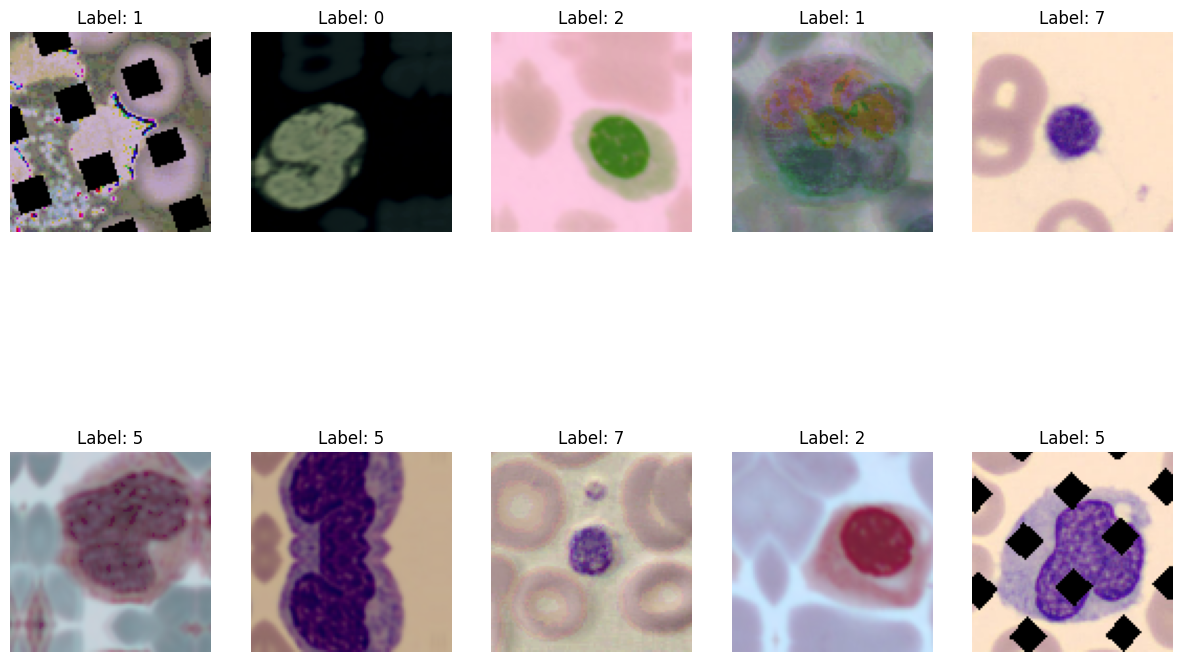

In [8]:
import matplotlib.pyplot as plt

# Plot 10 random images from X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X_train_combined.shape[0])
    plt.imshow(X_train_combined[random_idx])
    plt.title(f"Label: {np.argmax(y_train_combined[random_idx])}")
    plt.axis('off')
plt.show()

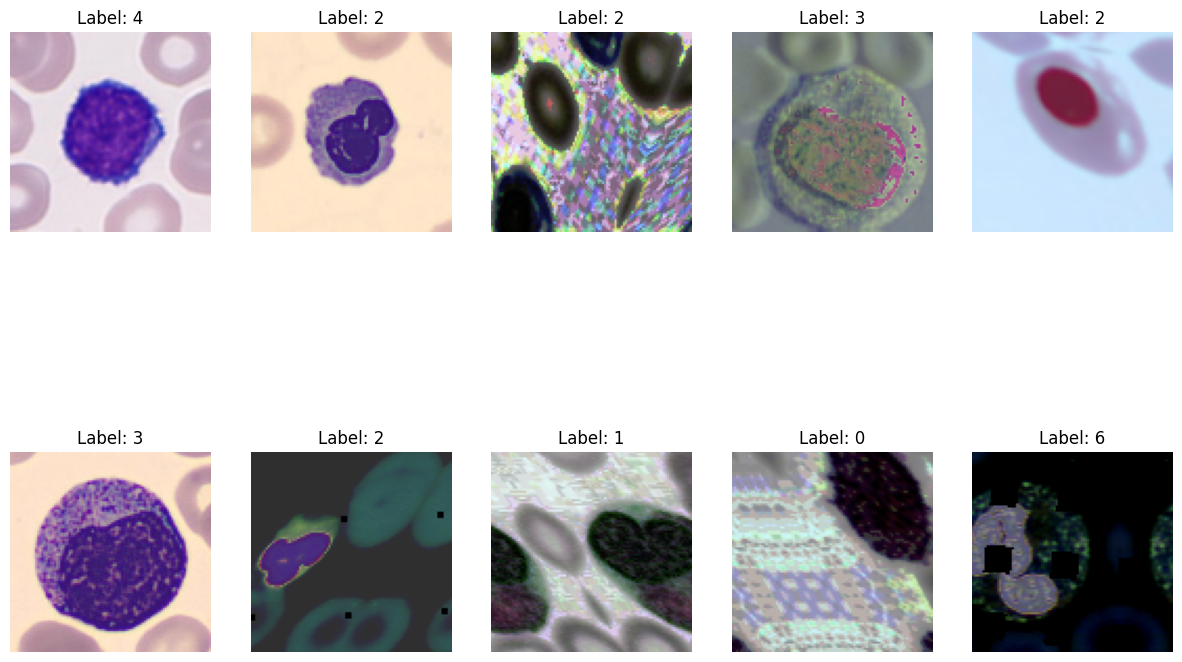

In [9]:
# Plot 10 random images from X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X_val_combined.shape[0])
    plt.imshow(X_val_combined[random_idx])
    plt.title(f"Label: {np.argmax(y_val_combined[random_idx])}")
    plt.axis('off')
plt.show()

In [10]:
# Define the FourierMix layer
fourier_mix = keras_cv.layers.FourierMix(alpha=0.5)

# Apply FourierMix augmentation dynamically
def apply_fourier_mix(images, labels):
    # Ensure the input batch has 2 or more samples
    labels = tf.cast(labels, tf.float32)
    augmented = fourier_mix({"images": images, "labels": labels})
    return augmented["images"], augmented["labels"]

# Create and batch the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_combined, y_train_combined))
train_dataset = train_dataset.batch(32)  # Batch size must be >= 2

# Integrate FourierMix into the pipeline
augmented_dataset = train_dataset.map(apply_fourier_mix).prefetch(tf.data.AUTOTUNE)

# Prepare the augmented dataset for saving
X_augmented, y_augmented = next(iter(augmented_dataset.unbatch().batch(len(X_train_combined))))

X_train_combined = X_augmented.numpy()
y_train_combined = y_augmented.numpy()


In [11]:
X_train_combined.shape

(91431, 96, 96, 3)

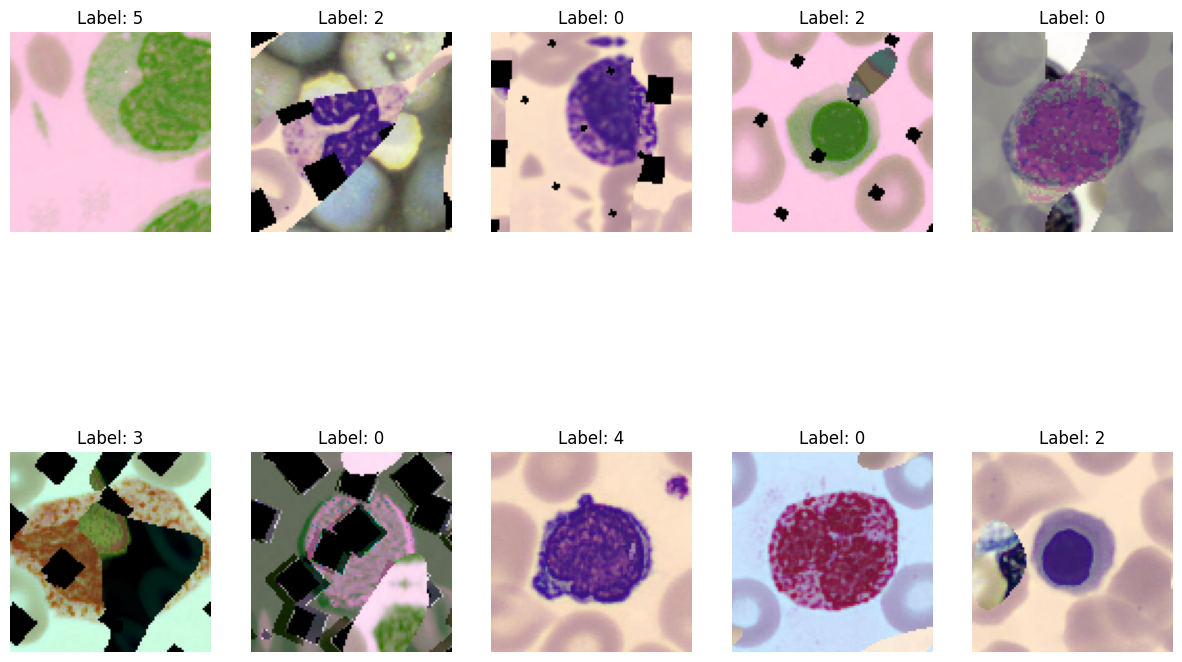

In [12]:
import matplotlib.pyplot as plt

# Plot 10 random images from X_train
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    random_idx = np.random.randint(0, X_train_combined.shape[0])
    plt.imshow(X_train_combined[random_idx])
    plt.title(f"Label: {np.argmax(y_train_combined[random_idx])}")
    plt.axis('off')
plt.show()

In [13]:
# Save the augmented data
np.savez(f"/kaggle/working/fourier_{train_augmentations_per_image}_nocleanval_balanced_heavy_full_and_augMix_training_data.npz",
         images=X_train_combined, labels=y_train_combined)

np.savez(f"/kaggle/working/fourier_{train_augmentations_per_image}_train_{val_augmentations_per_image}_val_noclean_balanced_heavy_full_and_augMix_validation_data.npz",
         images=X_val_combined, labels=y_val_combined)

print("Combined training and validation datasets saved successfully.")


Combined training and validation datasets saved successfully.
